In [2]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader

import cv2
import matplotlib.pyplot as plt
from qpm_datasets_correctScale import qpm_np_v4_CorrectedScale

from lff_model import final_model
import numpy as np

from utils.opticalTrain_utils import *
from utils.swinirTrain_utils import *
from utils.BothTrain_utils import *


#  [x64 comp]

## 1. Optical Training 

In [3]:
input_img_size= 32
final_img_size = 256
gpu_id= 0

upsampling_method= 'pixelshuffle' # 'nearest+conv'

cfg= {'img_size': final_img_size,
    'delta_z':  0.004,
    'lambda_': 750e-6,
    'neuron_size': 0.0003,
    'learn_type': 'both',
    'n_layers': 5,
    'in_dist': 0.004,
    'out_dist': 0.007,
    'window_size':4,  # used only in d2nnASwWindow(PhaseD2NN)

    ## swinIR parameters
    'gpu_ids': [gpu_id],
    'netG': {'img_size':input_img_size,
         'depths': [6, 6, 6, 6, 6, 6],
         'embed_dim': 180,
         'img_range': 1.0,
         'in_chans': 1,
         'init_type': 'default',
         'mlp_ratio': 2,
         'net_type': 'swinir',
         'num_heads': [6, 6, 6, 6, 6, 6],
         'resi_connection': '1conv',
         'scale': 1,
         'upsampler': upsampling_method,
         'window_size': 8}}


gpu_id= cfg['gpu_ids'][0]
cfg['device']= f'cuda:{gpu_id}'
device= cfg['device']

cfg['netG']['upscale']=  cfg['img_size']//cfg['netG']['img_size']

In [4]:
cfg['dataset_debug_opts'] = 'clip_phase'
cfg['angle_max']= '2*np.pi'

data_dir= '/n/holyscratch01/wadduwage_lab/D2NN_QPM_microscopy/datasets/qpm_np_v4_CorrectScale'

remove_inverted= True
train_loader = DataLoader(qpm_np_v4_CorrectedScale(data_dir, type_= 'train', crop_size= cfg['img_size'], remove_inverted= remove_inverted),
                    batch_size=32, shuffle=False, num_workers=4, drop_last=True)

test_loader = DataLoader(qpm_np_v4_CorrectedScale(data_dir, type_= 'test', crop_size= cfg['img_size'], remove_inverted= remove_inverted),
                    batch_size=32, shuffle=False, num_workers=4, drop_last=True)

Removed inverted samples : 13.npy, 72.npy, 83.npy, 127.npy, 243.npy, 273.npy, 277.npy, 312.npy, 461.npy, 14.npy, 15.npy, 242.npy
Removed inverted samples : 13.npy, 72.npy, 83.npy, 127.npy, 243.npy, 273.npy, 277.npy, 312.npy, 461.npy, 14.npy, 15.npy, 242.npy


In [5]:
import os, shutil
img_size= cfg['img_size']
save_dir= f'results/LFF_DatasetHela_x64Comp'

try:shutil.rmtree(save_dir)
except:pass
os.makedirs(save_dir)

optical model training : >>> 1138/ 1500
optical model training : >>> 1139/ 1500
optical model training : >>> 1140/ 1500


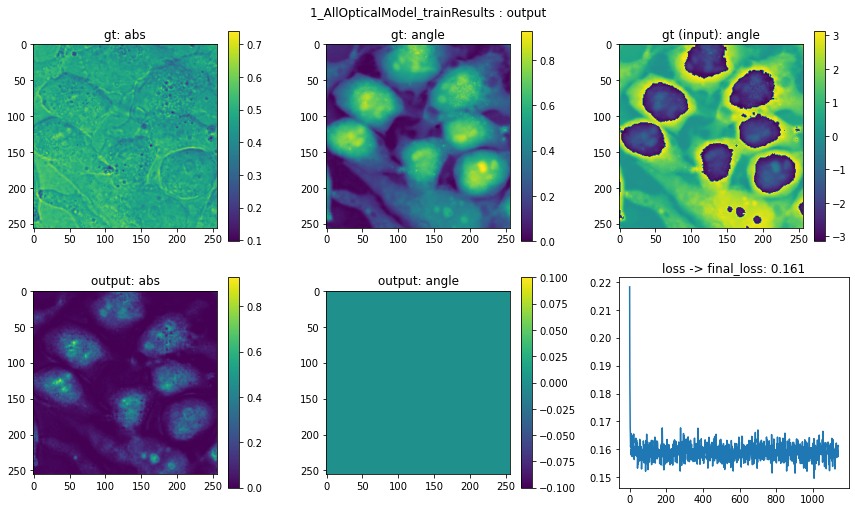

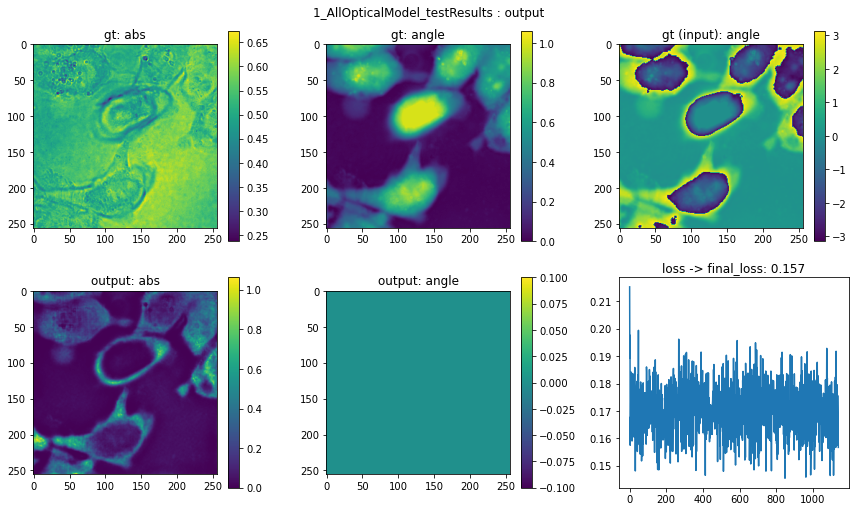

optical model training : >>> 1141/ 1500
optical model training : >>> 1142/ 1500
optical model training : >>> 1143/ 1500
optical model training : >>> 1144/ 1500


In [ ]:
code_testing= False

if code_testing:
    show_epoch= 6
    n_epochs= 6
else:
    show_epoch= 20
    n_epochs= 1500 # n_iter= 11 compared to 256 previously

criterion= nn.L1Loss().to(device)
lr= 0.1

optical_model = final_model(cfg, decoder_name= None).to(device)
opt= torch.optim.Adam(optical_model.parameters(), lr= lr)
scheduler = MultiStepLR(opt, milestones=[50, 400, 650, 1000, 1400], gamma=0.1)

loss_train, loss_test= [], []

for epoch in range(1, n_epochs+1):
    print(f'optical model training : >>> {epoch}/ {n_epochs}')

    losses_t= []
    optical_model.train()
    for i, gt in enumerate(train_loader):
        opt.zero_grad()

        gt= gt[:,0].to(device)
        input_img= gt.clone()

        out = optical_model(input_img)
        loss= criterion(out.abs(), (gt.angle()%(2*np.pi))/ (2*np.pi))
        loss.backward()
        opt.step()

        losses_t.append(loss.item())

    loss_train.append(np.mean(losses_t))
    if epoch% show_epoch == 0:
        show_results_AllOptical(gt, out, loss_train, f'1_AllOpticalModel_trainResults', save_dir)
        pass
    
    losses_t= []
    optical_model.eval()
    for i, gt in enumerate(test_loader):
        gt= gt[:,0].to(device)
        input_img= gt.clone()

        out = optical_model(input_img)
        loss= criterion(out.abs(), (gt.angle()%(2*np.pi))/ (2*np.pi))

        losses_t.append(loss.item())
        
    loss_test.append(np.mean(losses_t))
    if epoch% show_epoch == 0:
        show_results_AllOptical(gt, out, loss_test, f'1_AllOpticalModel_testResults', save_dir)
        torch.save(optical_model.state_dict(), f'{save_dir}/1_AllOpticalModel.pth')

    scheduler.step()

## 2. Optical-Electronic Training

In [ ]:
from SR_scripts.swinIR_support_files.models_define import swinIR_generative_model

In [ ]:
img_size= cfg['img_size']

optical_model.eval()

for name, param in optical_model.named_parameters():
    param.requires_grad= False
    print(f'freeze weights of optical network ---> {name} : {param.requires_grad}')

In [ ]:
%%capture

sr_opt_dir= 'SR_scripts/swinIR_support_files/opt_RealWorldSR.yaml'
sr_model = swinIR_generative_model(sr_opt_dir, cfg)
sr_model.init_train()

In [ ]:
n_epochs= 890 # n_iter= 11 compared to 256 previously
save_epoch= 10

if code_testing:
    n_epochs= 4
    save_epoch= 2

########
loss_train, loss_test= [], []
current_step= 1

upscale= cfg['netG']['upscale']

for epoch in range(1, n_epochs+1):
    print(f'epoch : {epoch}')
    losses_t= []
    for i, gt in enumerate(train_loader):
        current_step+=i
        gt= gt[:,0].to(device)
        gt_angle= (gt.angle()%(2*np.pi))/ (2*np.pi)

        optical_out = optical_model(gt).abs()
        optical_out = do_downsample(optical_out, upscale= upscale)

        sr_model.update_learning_rate(current_step)
        sr_model.feed_data({'L':optical_out.unsqueeze(dim=1), 'H':gt_angle.unsqueeze(dim=1)}) #out: recon_angle
        sr_model.optimize_parameters(current_step)
        decoder_out= sr_model.E[:,0]
        loss= sr_model.log_G_loss
        losses_t.append(loss.item())
        
        if code_testing and i==10:
            print('code testing activated: training is broken')
            break
    loss_train.append(np.mean(losses_t))
    if epoch%save_epoch==0:show_results_SwinIRTraining(gt_angle, optical_out, decoder_out, loss_train, f'2_swinrIR(downscale{upscale})_trainResults', save_dir)
    print(f'in (encoder) shape : {gt.shape} | in (decoder) shape : {optical_out.shape} | recon shape : {decoder_out.shape}')
    
    ##test
    losses_t= []
    for i, gt in enumerate(test_loader):
        gt= gt[:,0].to(device)
        gt_angle= (gt.angle()%(2*np.pi))/ (2*np.pi)

        optical_out = optical_model(gt).abs()
        optical_out = do_downsample(optical_out, upscale= upscale)

        sr_model.feed_data({'L':optical_out.unsqueeze(dim=1), 'H':gt_angle.unsqueeze(dim=1)}) #out: recon_angle
        sr_model.test()
        decoder_out= sr_model.E[:,0]
        loss = sr_model.log_G_loss # THIS IS THE TRAINING LOSS (.test() will not compute the loss) -> not a problem because GANs dont overfit
        losses_t.append(loss.item())
        
        if code_testing and i==10:
            print('code testing activated: training is broken')
            break
    loss_test.append(np.mean(losses_t))
    print(f'in (encoder) shape : {gt.shape} | in (decoder) shape : {optical_out.shape} | recon shape : {decoder_out.shape}')
    
    if epoch%save_epoch==0:
        show_results_SwinIRTraining(gt_angle, optical_out, decoder_out, loss_train, f'2_swinrIR(downscale{upscale})_testResults', save_dir)
        model_details= {
            'sr_opt_dir': sr_opt_dir,
            'cfg': cfg,
            #'Optical_state_dict_dir': optical_state_dict_dir,
            'SR_state_dict': sr_model.state_dict(),
            'loss_train': loss_train,
            'loss_test': loss_test,
            'epoch': epoch}

        torch.save(model_details, f'{save_dir}/2_swinrIR(downscale{upscale}).pth')

# 3. Optical + Electronic

In [ ]:
from SR_scripts.swinIR_support_files.losses import *
from torch.optim.lr_scheduler import MultiStepLR
from collections import Counter

In [ ]:
ssim= SSIMLoss().to(device)
l1= nn.L1Loss().to(device)

def criterion_BothTrain(out, gt): #shape: (b, img, img)
    loss= -ssim(out.unsqueeze(dim=1), gt.unsqueeze(dim=1))
    return loss

In [ ]:
freeze_params(sr_model.netG, requires_grad= True)
freeze_params(optical_model, requires_grad= True)

train_losses, train_psnrs, train_ssims, train_l1s= [], [], [], []
test_losses, test_psnrs, test_ssims, test_l1s= [], [], [], []
start_epoch= 1

opt= torch.optim.Adam([{'params':sr_model.parameters()}, {'params':optical_model.parameters()}], lr= 0.000005)
scheduler = MultiStepLR(opt, milestones=[100000, 150000, 200000], gamma=0.1)

In [ ]:
model_path = f'{save_dir}/3_TrainBoth(downscale{upscale}).pth'
n_epochs= 10000
save_epoch= 20

if code_testing:
    n_epochs=3
    save_epoch= 1
    
upscale= cfg['netG']['upscale']
if code_testing:
    weights_optical_init= [param.detach().cpu().numpy() for name, param in optical_model.named_parameters()]
    weights_srmodel_init= [param.detach().cpu().numpy() for name, param in sr_model.named_parameters()]

for epoch in range(start_epoch, start_epoch+n_epochs+1):
    if epoch==1 and code_testing:        
        weights_optical2= [param.detach().cpu().numpy() for name, param in optical_model.named_parameters()]
        weights_srmodel2= [param.detach().cpu().numpy() for name, param in sr_model.named_parameters()]

        print(f'Initial: Are models still similar: Weights Similarity ---> optical : {100*get_similarity_model(weights_optical_init, weights_optical2)} % | swinIR : {100*get_similarity_model(weights_srmodel_init, weights_srmodel2)} %')

    loss_t, psnr_t, ssim_t, l1_t= [], [], [], []
    optical_model.train()
    for i, gt in enumerate(train_loader):
        if code_testing and i>5:break
        opt.zero_grad()
        gt= gt[:,0].to(device)
        gt_angle= (gt.angle()%(2*np.pi))/ (2*np.pi)
        optical_out = optical_model(gt).abs()
        optical_out = do_downsample(optical_out, upscale= upscale)

        sr_model.feed_data({'L':optical_out.unsqueeze(dim=1), 'H':gt_angle.unsqueeze(dim=1)}) #out: recon_angle
        sr_model.netG_forward()
        decoder_out= sr_model.E[:,0]        
        loss= criterion_BothTrain(decoder_out, gt_angle)
        loss.backward()
        opt.step()

        loss_t.append(loss.item())
        ssim_t.append(ssim_grayscale(decoder_out.unsqueeze(dim=1), gt_angle.unsqueeze(dim=1)))
        psnr_t.append(psnr_grayscale(decoder_out.unsqueeze(dim=1), gt_angle.unsqueeze(dim=1)))
        l1_t.append(l1(decoder_out, gt_angle).item())
    train_losses.append(np.mean(loss_t))
    train_psnrs.append(np.mean(psnr_t))
    train_ssims.append(np.mean(ssim_t))
    train_l1s.append(np.mean(l1_t))
    
    if epoch%save_epoch==0:
        show_results_BothTraining(gt_angle, optical_out, decoder_out, train_losses, train_psnrs, train_ssims, train_l1s, f'3_TrainBoth(downscale{upscale})_trainResults', f'lr:{scheduler.get_last_lr()}, after_epoch:{epoch}', save_dir)

    loss_t, psnr_t, ssim_t, l1_t= [], [], [], []
    optical_model.eval()
    for i, gt in enumerate(test_loader):
        if code_testing and i>5:break
        gt= gt[:,0].to(device)
        gt_angle= (gt.angle()%(2*np.pi))/ (2*np.pi)
        optical_out = optical_model(gt).abs()
        optical_out = do_downsample(optical_out, upscale= upscale)

        sr_model.feed_data({'L':optical_out.unsqueeze(dim=1), 'H':gt_angle.unsqueeze(dim=1)}) #out: recon_angle
        sr_model.test()
        decoder_out= sr_model.E[:,0]        

        loss_t.append(loss.item())
        ssim_t.append(ssim_grayscale(decoder_out.unsqueeze(dim=1), gt_angle.unsqueeze(dim=1)))
        psnr_t.append(psnr_grayscale(decoder_out.unsqueeze(dim=1), gt_angle.unsqueeze(dim=1)))
        l1_t.append(l1(decoder_out, gt_angle).item())
        
    test_losses.append(np.mean(loss_t))
    test_psnrs.append(np.mean(psnr_t))
    test_ssims.append(np.mean(ssim_t))
    test_l1s.append(np.mean(l1_t))
    
    if epoch%save_epoch==0:
        show_results_BothTraining(gt_angle, optical_out, decoder_out, test_losses, test_psnrs, test_ssims, test_l1s, f'3_TrainBoth(downscale{upscale})_testResults', f'lr:{scheduler.get_last_lr()}, after_epoch:{epoch}', save_dir)

        model_details= {
            #'pretrained_optical_state_dict_dir': optical_state_dict_dir,
            #'pretrained_swinir_state_dict_dir': 'results/4_TrainSRSeparate_wCorrectScale_Img256/swinrIR_decoder(no_decoder)_downscale(8).pth',
            'sr_opt_dir': sr_opt_dir,
            'cfg': cfg,
            'sR_state_dict': sr_model.state_dict(),
            'optical_state_dict': optical_model.state_dict(),
            'metrics_train': {'loss': train_losses, 'psnr': train_psnrs, 'ssim': train_ssims, 'l1': train_l1s},
            'metrics_test': {'loss': test_losses, 'psnr': test_psnrs, 'ssim': test_ssims, 'l1': test_l1s},
            'epoch': epoch,
            'opt_state_dict': opt.state_dict(),
            'scheduler_state_dict': scheduler.state_dict()}
        torch.save(model_details, model_path)
        
        if code_testing:
            weights_optical2= [param.detach().cpu().numpy() for name, param in optical_model.named_parameters()]
            weights_srmodel2= [param.detach().cpu().numpy() for name, param in sr_model.named_parameters()]

            print(f'after {epoch}: Are models still similar: Weights Similarity ---> optical : {100*get_similarity_model(weights_optical_init, weights_optical2)} % | swinIR : {100*get_similarity_model(weights_srmodel_init, weights_srmodel2)} %')
    
    scheduler.step()